## **About this Script**

This script will create a convolutional neural network (CNN) in python code, classifying chest X-ray images for patients with Pneumonia or 'Normal' lungs. 

Furthermore, if pneumonia is classified, the image will further be identified based on the type of infection (bacterial, or viral).

If you have questions, please contact: maese005@umn.edu

## **Step 1:** Get Data

First, mount your Google Drive to your Google Colab.

This will allow you to share files and access images stored in Google Drive from Google Collab.

Once you run this code, you will receive a prompt asking you to click a link. When you click on this link, it will allow for 'Google Files Stream' to access your drive. 

After, you will receive a long authentication code which you need to copy and enter into your Colab's notebook. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now that your Google Drive is mounted to your Google Drive, you must obtain the data for this script. 

The data can be obtained at this link: https://drive.google.com/drive/folders/1j-c1aGvZzRMP2Q1H11XJlWi7Z-ZYPEfe?usp=sharing

To access the data from your Google Drive, click on the link. Then, select **images** and **Add shortcut to drive**

Adding a shortcut allows for quick data transfer to your Google Drive. Otherwise, depending on your computer, it could take a long time!

## **Step 2:** Load Modules

A python module is an object that can store functions and variables, etc. 

In [ ]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Model, load_model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten
np.random.seed(22)
from keras.preprocessing.image import ImageDataGenerator

## **Step 3:** Define Functions

Next, define functions that will prepare both the normal and pneumonia images for training and testing.

These functions were written based on how the image dataset is currently labeled. 

In [ ]:
def load_normal(norm_path):
    norm_files = np.array(os.listdir(norm_path))
    norm_labels = np.array(['normal']*len(norm_files))
    
    norm_images = []
    for image in tqdm(norm_files):
        image = cv2.imread(norm_path + image)
        image = cv2.resize(image, dsize=(200,200))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        norm_images.append(image)
        
    norm_images = np.array(norm_images)
    
    return norm_images, norm_labels

def load_pneumonia(pneu_path):
    pneu_files = np.array(os.listdir(pneu_path))
    pneu_labels = np.array([pneu_file.split('_')[1] for pneu_file in pneu_files])
    
    pneu_images = []
    for image in tqdm(pneu_files):
        image = cv2.imread(pneu_path + image)
        image = cv2.resize(image, dsize=(200,200))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        pneu_images.append(image)
        
    pneu_images = np.array(pneu_images)
    
    return pneu_images, pneu_labels

## **Step 4:** Prepare Training and Testing Data

You will have to modify the path to the dataset below in order for your computer to successfully access it. I chose to store my images folder in a directory called AI_Workshop. I'm assuming most users will use **/content/drive/My Drive/images/'** instead.

In [ ]:
!ls '/content/drive/My Drive/AI_Workshop/images/' 
#Use the list command to see what is stored at this location. Based on the output, there are two directories titled, 'test' and 'train'

test  train


In [ ]:
norm_images_train, norm_labels_train = load_normal('/content/drive/My Drive/AI_Workshop/images/train/normal/')

100%|██████████| 1349/1349 [07:05<00:00,  3.17it/s]


In [ ]:
pneu_images_train, pneu_labels_train = load_pneumonia('/content/drive/My Drive/AI_Workshop/images/train/pneumonia/')

100%|██████████| 3883/3883 [15:50<00:00,  4.09it/s]


Prepare X and y training data.

In [ ]:
X_train=np.append(norm_images_train, pneu_images_train, axis=0)
y_train=np.append(norm_labels_train, pneu_labels_train)

Determine the number of samples for each class. 

In [ ]:
np.unique(y_train, return_counts=True)

(array(['bacteria', 'normal', 'virus'], dtype='<U8'),
 array([2538, 1349, 1345]))

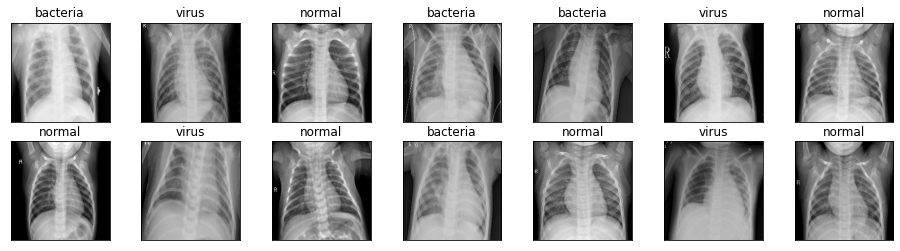

In [ ]:
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(16, 4))

indices = np.random.choice(len(X_train), 14)
counter = 0

for i in range(2):
    for j in range(7):
        axes[i,j].set_title(y_train[indices[counter]])
        axes[i,j].imshow(X_train[indices[counter]], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        counter += 1
plt.show()

Load testing images. 

In [ ]:
norm_images_test, norm_labels_test = load_normal('/content/drive/My Drive/AI_Workshop/images/test/normal/')
pneu_images_test, pneu_labels_test = load_pneumonia('/content/drive/My Drive/AI_Workshop/images/test/pneumonia/')

100%|██████████| 390/390 [00:05<00:00, 66.93it/s]


Prepare X and y test.

In [ ]:
X_test=np.append(norm_images_test, pneu_images_test, axis=0)
y_test=np.append(norm_labels_test, pneu_labels_test)

## **Step 5:** Preprocess the Data

Preprocess the labels into a format that will be acceptable to the neural network.

This step, as all data preprocessing steps are, is tricky and requires some thought. 

Here, we will use sklearn's **OneHotEncoder** function to encode categorical features as a one-hot numeric array. Because this function transforms the data, it is called a transformer. This encoding is required in order to feed categorical data to many scikit-learn estimators. Specifically, Sklearn's One-Hot encoding is a technique used to represent categorical data in the form of binary vectors. It is a common step prior to performing classification. 

We will then apply the **fit_transform** function to this one-hot numeric array. This function will fit the OneHotEncoder to the training data then transform it. 

Additional information about OneHotEncoder can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

Additional information about data preprocessing can be found here: https://towardsdatascience.com/data-preprocessing-and-network-building-in-cnn-15624ef3a28b

In [ ]:
y_train=y_train[:, np.newaxis]
y_test=y_test[:, np.newaxis]
one_hot_encoder=OneHotEncoder(sparse=False)
y_train_one_hot=one_hot_encoder.fit_transform(y_train) #This will provide us with a transformed response. 
y_test_one_hot=one_hot_encoder.fit_transform(y_test) #This will provide us with a transformed response.

Reshape your X data (input/images) into number of samples, height, width, 1 (which represents a single color channel). 

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

Data augmentation step.

This step will generate new images using randomness.

In [ ]:
datagen = ImageDataGenerator(
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

In [ ]:
datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train_one_hot, batch_size = 32)

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
print(input_shape)

input1 = Input(shape=input_shape)

cnn = Conv2D(16, (3, 3), activation='relu', strides=(1, 1), 
    padding='same')(input1)
cnn = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = MaxPool2D((2, 2))(cnn)

cnn = Conv2D(16, (2, 2), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = Conv2D(32, (2, 2), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = MaxPool2D((2, 2))(cnn)

cnn = Flatten()(cnn)
cnn = Dense(100, activation='relu')(cnn)
cnn = Dense(50, activation='relu')(cnn)
output1 = Dense(3, activation='softmax')(cnn)

model = Model(inputs=input1, outputs=output1)

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['acc'])

(200, 200, 1)


## **Step 6:** Fit the Model

Using fit_generator() instead of fit() because we are going to use data taken from the generator. Note that the randomness is changing on each epoch.

In [ ]:
history = model.fit_generator(train_gen, epochs=30, validation_data=(X_test, y_test_one_hot))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
164/164 [==============================] - 377s 2s/step - loss: 45.2003 - acc: 0.4858 - val_loss: 0.8321 - val_acc: 0.7003
Epoch 2/30
164/164 [==============================] - 381s 2s/step - loss: 0.7046 - acc: 0.6964 - val_loss: 0.8371 - val_acc: 0.6683
Epoch 3/30
164/164 [==============================] - 378s 2s/step - loss: 0.6376 - acc: 0.7357 - val_loss: 0.7046 - val_acc: 0.7660
Epoch 4/30
164/164 [==============================] - 376s 2s/step - loss: 0.6179 - acc: 0.7391 - val_loss: 1.0237 - val_acc: 0.6811
Epoch 5/30
164/164 [==============================] - 376s 2s/step - loss: 0.6204 - acc: 0.7384 - val_loss: 0.9458 - val_acc: 0.7083
Epoch 6/30
164/164 [==============================] - 375s 2s/step - loss: 0.6027 - acc: 0.7384 - val_loss: 0.7518 - val_acc: 0.7484
Epoch 7/30
164/164 [==============================] - 377s 2s/step - loss: 0.6016 - acc: 0.7493 - val_loss: 0.8313 - val_acc: 0.7276
Epoch 8/30
164/164 [==============================] - 379s 2s/step -

## **Step 6:** Display the Accuracy

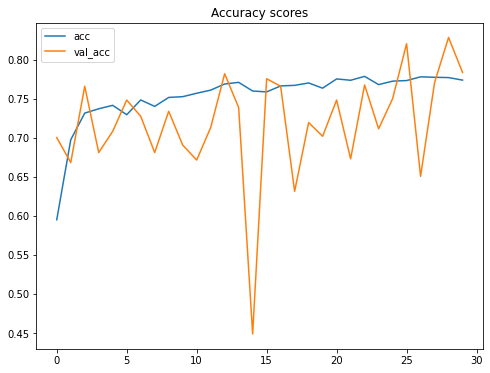

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.show()

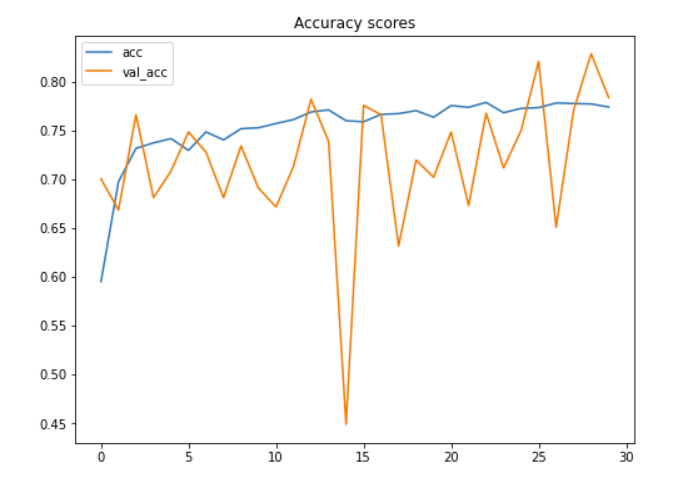

Display loss. 

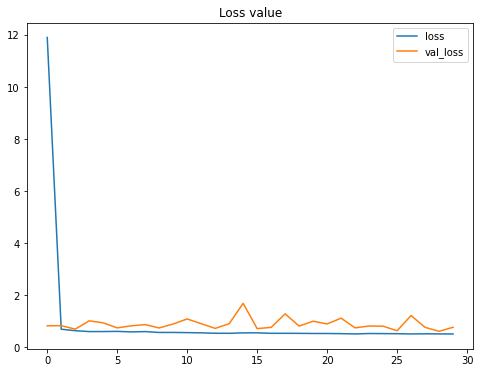

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

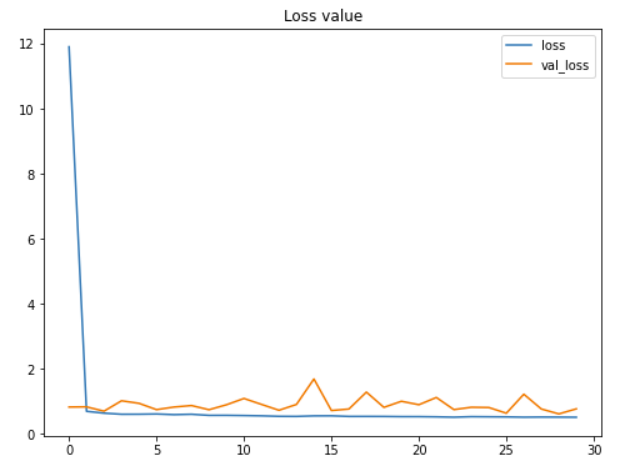

Predict on test data.

In [ ]:
predictions=model.predict(X_test)

In [ ]:
predictions = one_hot_encoder.inverse_transform(predictions)

print('Model evaluation')
print(one_hot_encoder.categories_)

classnames = ['bacteria', 'normal', 'virus']

Model evaluation
[array(['bacteria', 'normal', 'virus'], dtype='<U8')]


Display the confusion matrix. 

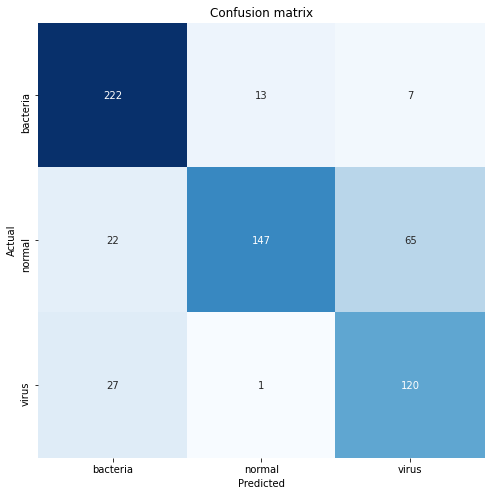

In [ ]:
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8,8))
plt.title('Confusion matrix')
sns.heatmap(cm, cbar=False, xticklabels=classnames, yticklabels=classnames, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

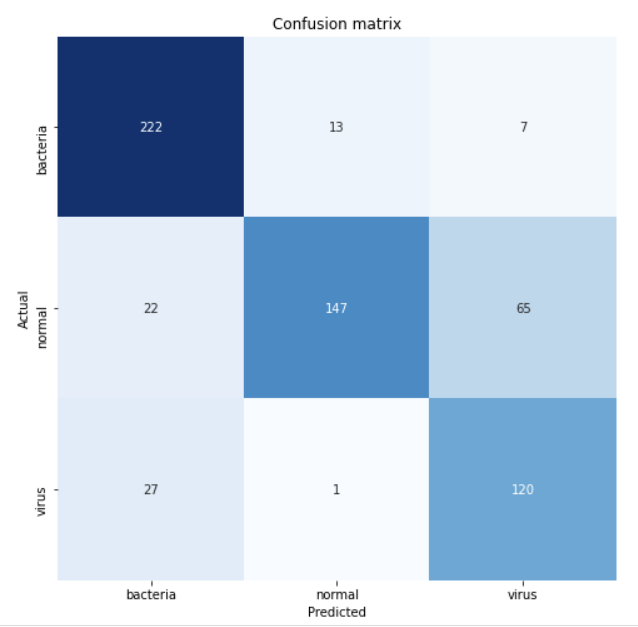